
# Previsão de Atraso de Entrega — Olist (Comparação: XGBoost × LightGBM × CatBoost)

Notebook **completo** e **autocontido** para portfólio: cria *features*, treina e compara três modelos populares de *gradient boosting* com métricas adequadas ao desbalanceamento (**PR-AUC**, **F1**, **Precision**, **Recall**), além de curvas de **Precision-Recall**.

> **IMPORTANTE:** Ajuste `OLIST_BASE_PATH` para apontar aos CSVs originais da Olist (Kaggle) antes de executar.


In [3]:

# =============== 1) Setup ===============
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, classification_report, roc_auc_score,
    average_precision_score, confusion_matrix
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
os.environ["OLIST_BASE_PATH"] = "data"

# Verifica bibliotecas opcionais
HAS_LGB = False
HAS_CB  = False
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    HAS_LGB = True
except Exception as e:
    print("[Aviso] lightgbm indisponível. Instale com: pip install lightgbm")

try:
    from catboost import CatBoostClassifier
    HAS_CB = True
except Exception as e:
    print("[Aviso] catboost indisponível. Instale com: pip install catboost")

from xgboost import XGBClassifier


In [4]:

# =============== 2) Carregamento dos dados ===============
# Ajuste ESTE caminho para os CSVs originais da Olist (Kaggle).
OLIST_BASE_PATH = os.getenv("OLIST_BASE_PATH", "")

def load_csv(name):
    path = os.path.join(OLIST_BASE_PATH, name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    return pd.read_csv(path)

orders    = load_csv("olist_orders_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
items     = load_csv("olist_order_items_dataset.csv")
sellers   = load_csv("olist_sellers_dataset.csv")
geos      = load_csv("olist_geolocation_dataset.csv")

# (Opcional) payments: load_csv("olist_order_payments_dataset.csv")
print("Loaded:",
      orders.shape, customers.shape, items.shape, sellers.shape, geos.shape)


Loaded: (99441, 8) (99441, 5) (112650, 7) (3095, 4) (1000163, 5)


In [13]:

# =============== 3) Pré-limpeza e merges essenciais ===============
# Timestamps
for col in ["order_purchase_timestamp","order_approved_at",
            "order_delivered_carrier_date","order_delivered_customer_date",
            "order_estimated_delivery_date"]:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors="coerce")

# Target e filtro básico
orders["was_delivered"] = orders["order_delivered_customer_date"].notna().astype(int)
orders["is_late"] = (
    (orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]) &
    orders["order_estimated_delivery_date"].notna()
).astype(int)

# Agregações de itens por pedido
agg_items = items.groupby("order_id").agg(
    n_items=("order_item_id","count"),
    n_sellers=("seller_id","nunique"),
    price_sum=("price","sum"),
    freight_sum=("freight_value","sum")
).reset_index()

# Latitude/Longitude por vendedor (via CEP aproximado)
sellers_geo = sellers.merge(
    geos.rename(columns={"geolocation_zip_code_prefix":"seller_zip_code_prefix"}),
    on="seller_zip_code_prefix", how="left"
).groupby("seller_id").agg(
    sell_lat_mean=("geolocation_lat","mean"),
    sell_lng_mean=("geolocation_lng","mean"),
    seller_state=("seller_state","first")
).reset_index()

items_sg = items.merge(sellers_geo, on="seller_id", how="left")
items_geo_agg = items_sg.groupby("order_id").agg(
    sell_lat_mean=("sell_lat_mean","mean"),
    sell_lng_mean=("sell_lng_mean","mean"),
    n_seller_states=("seller_state","nunique")
).reset_index()

# Latitude/Longitude do cliente (via CEP aproximado)
cust_geo = customers.merge(
    geos.rename(columns={"geolocation_zip_code_prefix":"customer_zip_code_prefix"}),
    on="customer_zip_code_prefix", how="left"
).groupby("customer_id").agg(
    cust_lat=("geolocation_lat","mean"),
    cust_lng=("geolocation_lng","mean"),
    customer_city=("customer_city","first"),
    customer_state=("customer_state","first")
).reset_index()

# Merge final
df = orders.merge(customers.drop(columns=["customer_city","customer_state"]), on="customer_id", how="left")
df = df.merge(agg_items, on="order_id", how="left")
df = df.merge(items_geo_agg, on="order_id", how="left")
df = df.merge(cust_geo[["customer_id","cust_lat","cust_lng","customer_city","customer_state"]],
              on="customer_id", how="left")

print("df shape:", df.shape)
df.head(3)


df shape: (99441, 23)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,was_delivered,is_late,...,n_sellers,price_sum,freight_sum,sell_lat_mean,sell_lng_mean,n_seller_states,cust_lat,cust_lng,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,0,...,1.0,29.99,8.72,-23.680729,-46.444238,1.0,-23.576983,-46.587161,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,0,...,1.0,118.70,22.76,-19.807681,-43.980427,1.0,-12.177924,-44.660711,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,0,...,1.0,159.90,19.22,-21.363502,-48.229601,1.0,-16.745150,-48.514783,vianopolis,GO


In [14]:

# =============== 4) Feature Engineering ===============
# 4.1 Região do cliente
regioes = {
    "N": {"AC","AP","AM","PA","RO","RR","TO"},
    "NE": {"AL","BA","CE","MA","PB","PE","PI","RN","SE"},
    "CO": {"DF","GO","MS","MT"},
    "SE": {"ES","MG","RJ","SP"},
    "S": {"PR","RS","SC"}
}
def uf_to_region(uf):
    if pd.isna(uf): return "UNK"
    uf = str(uf).upper()
    for r,ufs in regioes.items():
        if uf in ufs: return r
    return "UNK"

df["customer_region"] = df["customer_state"].apply(uf_to_region)

# 4.2 Distância Haversine (cliente x vendedores médios)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

df["distance"] = haversine_km(df["cust_lat"], df["cust_lng"], df["sell_lat_mean"], df["sell_lng_mean"])

# 4.3 Sazonalidade e feriado
df["purchase_weekday"] = df["order_purchase_timestamp"].dt.weekday
df["purchase_month"]   = df["order_purchase_timestamp"].dt.month

try:
    import holidays
    br_holidays = holidays.Brazil()
    df["is_holiday"] = df["order_purchase_timestamp"].dt.date.apply(
        lambda d: int(d in br_holidays) if pd.notna(d) else 0
    )
except Exception:
    df["is_holiday"] = 0

# 4.4 Tempos e razões
df["processing_time"] = (
    df["order_delivered_carrier_date"] - df["order_approved_at"]
).dt.total_seconds()/86400.0

df["freight_ratio"]    = df["freight_sum"] / (df["price_sum"] + 1e-6)
df["items_per_seller"] = df["n_items"] / (df["n_sellers"] + 1e-6)
df["avg_item_price"]   = df["price_sum"] / (df["n_items"] + 1e-6)
df["avg_freight_item"] = df["freight_sum"] / (df["n_items"] + 1e-6)

# Flag de geolocalização completa
df["has_geo"] = df[["cust_lat","cust_lng","sell_lat_mean","sell_lng_mean"]].notna().all(axis=1).astype(int)

print(df[["distance","purchase_weekday","purchase_month","is_holiday","processing_time"]].head(3))


     distance  purchase_weekday  purchase_month  is_holiday  processing_time
0   18.576110                 0              10           0         2.366493
1  851.495069                 1               7           0         0.462882
2  514.410666                 2               8           0         0.204595


In [15]:

# =============== 5) Seleção de features e target ===============
df_model = df[df["was_delivered"]==1].copy()
df_model = df_model.dropna(subset=["is_late"])

drop_cols = [
    "order_id","customer_id","was_delivered",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "order_approved_at","order_delivered_carrier_date","order_purchase_timestamp"
]
drop_cols = [c for c in drop_cols if c in df_model.columns]

y = df_model["is_late"].astype(int)
X = df_model.drop(columns=drop_cols + ["is_late"], errors="ignore")

# Booleans -> numéricos
bool_cols = X.select_dtypes(include="boolean").columns
if len(bool_cols)>0:
    X[bool_cols] = X[bool_cols].astype("int8")

print("Shapes -> X:", X.shape, "| y:", y.shape, "| atraso %:", y.mean().round(4))


Shapes -> X: (96476, 25) | y: (96476,) | atraso %: 0.0811


In [17]:

# =============== 6) Split e Pré-processamento ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_exclude=np.number)

num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])
cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_selector),
        ("cat", cat_tf, categorical_selector)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [18]:

# =============== 7) Utilitários de avaliação ===============
def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*(prec*rec)/(prec+rec+1e-9)
    i = int(np.argmax(f1))
    t_best = thr[i] if len(thr)>0 else 0.5
    return float(t_best), float(prec[i]), float(rec[i]), float(f1[i])

def eval_model(name, y_true, y_prob, plot=True):
    pr_auc = average_precision_score(y_true, y_prob)
    roc    = roc_auc_score(y_true, y_prob)
    thr, p, r, f1 = best_threshold_by_f1(y_true, y_prob)
    if plot:
        pr, rc, _ = precision_recall_curve(y_true, y_prob)
        plt.figure(figsize=(6,5))
        plt.plot(rc, pr)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve — {name}")
        plt.show()
    return {
        "model": name,
        "threshold*": thr,
        "F1@thr*": f1,
        "Precision@thr*": p,
        "Recall@thr*": r,
        "PR-AUC": pr_auc,
        "ROC-AUC": roc
    }


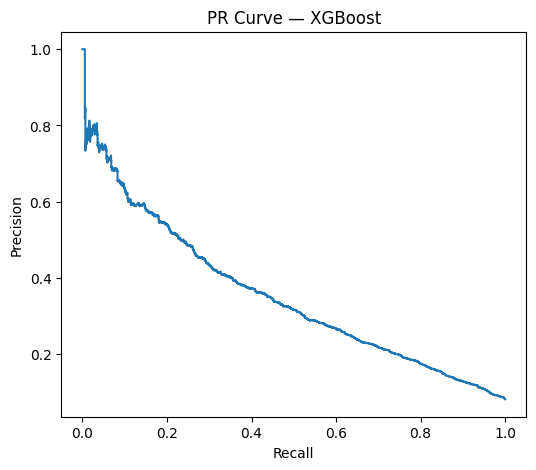

[LightGBM] [Info] Number of positive: 6262, number of negative: 70918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4121
[LightGBM] [Info] Number of data points in the train set: 77180, number of used features: 515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081135 -> initscore=-2.427025
[LightGBM] [Info] Start training from score -2.427025


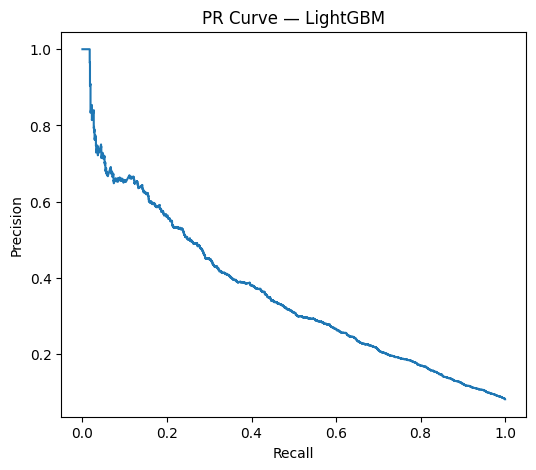

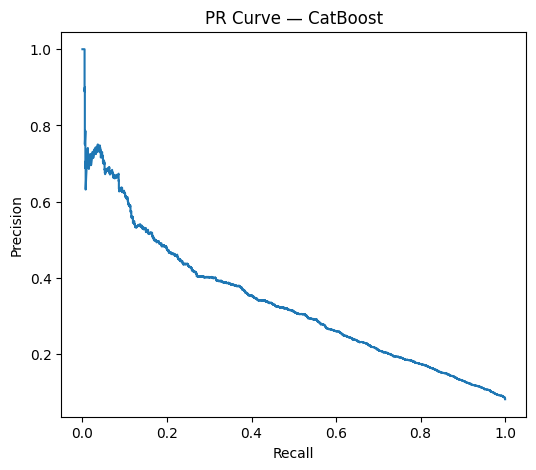

,model,threshold*,F1@thr*,Precision@thr*,Recall@thr*,PR-AUC,ROC-AUC
0,LightGBM,0.193964,0.394611,0.371268,0.421086,0.359970,0.805927
1,XGBoost,0.693189,0.391771,0.358431,0.431949,0.353301,0.811419
2,CatBoost,0.646319,0.385842,0.304702,0.525879,0.335693,0.810521


In [20]:

# =============== 8) Treino e comparação (XGB, LGBM, CB) ===============
rows = []

# XGBoost
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
xgb = Pipeline(steps=[
    ("pre", pre),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=1100,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        n_jobs=-1,
        random_state=SEED,
        scale_pos_weight=scale_pos_weight
    ))
])
xgb.fit(X_train, y_train)
yp_xgb = xgb.predict_proba(X_test)[:,1]
rows.append(eval_model("XGBoost", y_test, yp_xgb, plot=True))

# LightGBM
if HAS_LGB:
    lgbm = Pipeline(steps=[
        ("pre", pre),
        ("model", LGBMClassifier(
            objective="binary",
            n_estimators=1200,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=SEED,
            n_jobs=-1
        ))
    ])
    lgbm.fit(X_train, y_train)
    yp_lgb = lgbm.predict_proba(X_test)[:,1]
    rows.append(eval_model("LightGBM", y_test, yp_lgb, plot=True))
else:
    print("[Skip] LightGBM não instalado.")

# CatBoost
if HAS_CB:
    cb = Pipeline(steps=[
        ("pre", pre),
        ("model", CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="PRAUC",
            iterations=1200,
            learning_rate=0.05,
            depth=6,
            random_seed=SEED,
            verbose=False,
            auto_class_weights="Balanced"
        ))
    ])
    cb.fit(X_train, y_train)
    yp_cb = cb.predict_proba(X_test)[:,1]
    rows.append(eval_model("CatBoost", y_test, yp_cb, plot=True))
else:
    print("[Skip] CatBoost não instalado.")

# Tabela comparativa
df_cmp = pd.DataFrame(rows).sort_values(by=["F1@thr*","PR-AUC"], ascending=False).reset_index(drop=True)
df_cmp


In [25]:

# =============== 9) Relatórios por modelo @ threshold ótimo (F1) ===============
def report(name, y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n=== {name} @ thr={thr:.3f} ===")
    print(classification_report(y_true, y_pred, digits=3))

for row in rows:
    name = row["model"]
    thr  = row["threshold*"]
    if name == "XGBoost":
        report(name, y_test, yp_xgb, thr)
    elif name == "LightGBM" and 'yp_lgb' in globals():
        report(name, y_test, yp_lgb, thr)
    elif name == "CatBoost" and 'yp_cb' in globals():
        report(name, y_test, yp_cb, thr)



=== XGBoost @ thr=0.693 ===
              precision    recall  f1-score   support

           0      0.949     0.932     0.940     17731
           1      0.358     0.432     0.392      1565

    accuracy                          0.891     19296
   macro avg      0.654     0.682     0.666     19296
weighted avg      0.901     0.891     0.896     19296


=== LightGBM @ thr=0.194 ===
              precision    recall  f1-score   support

           0      0.948     0.937     0.943     17731
           1      0.371     0.421     0.395      1565

    accuracy                          0.895     19296
   macro avg      0.660     0.679     0.669     19296
weighted avg      0.901     0.895     0.898     19296


=== CatBoost @ thr=0.646 ===
              precision    recall  f1-score   support

           0      0.955     0.894     0.924     17731
           1      0.305     0.526     0.386      1565

    accuracy                          0.864     19296
   macro avg      0.630     0.710     0


## 10) Observações finais

- **Métrica principal**: **PR-AUC** (Average Precision), indicada para classes desbalanceadas.  
- **Threshold ótimo por F1**: ajusta *precision×recall* conforme a meta do negócio; pode-se otimizar por **custo** se *FN* forem mais caros.  
